Let $\tau_i$ denote the membrane time constant of neuron $i$. Then, up to the approximations related to the assumption of being in an Asynchronous Irregular state, we have the following forumalas for the mean and SD (standard deviation) of the input to different neurons. 

$\mu_i = \tau_i \sum_j W_{ij} r_j + h_i$

$\sigma^2_i = \tau_i \sum_j W_{ij}^2 r_j + \xi^2_i$

where $h_i$ and $\xi_i$ are the mean (which is positive) and SD of the external input, respectively.

And then the output firing rate of each neuron is given by 

$r_i = \Phi(\mu_i, \sigma_i) \qquad\qquad\qquad$     (1)

If I plug in the first two equations (where each is really $N$ equations) in the bottom one (again, really $N$ equations), then I obtain a system of $N$ equations for the $N$ unknowns, namely the $r_i$.  (part of) Your tasks is to solve this ssytem of equations. To do that, we will first promote these to time-dependent ODE's. These are auxiliary tools for us to find the fixed point, and are not really physical:

$T_i\frac{dr_i}{dt} + r_i = \Phi(\mu_i, \sigma_i)$

We will then solve these numerically using the Euler method (see my `utils_for_max.py`), and hope that the ODE's will converge onto a fixed point, which satisfies (1). The Euler discretization leads to

$r_i(t+1) = (1 - \alpha_i) r_i(t) + \alpha_i \Phi(\mu_i, \sigma_i)$

where I defined $\alpha_i = \frac{\delta t}{T_i}$. But to use `utils_for_max.Euler2fixedpt` you don't really need to do this, but you need to give it (as `dxdt`) the following:

$T_i^{-1} (-r_i + \Phi(\mu_i, \sigma_i))$ with the above expressions for $\mu$ and $\sigma$ plugged in. 


In the rest, I assume that you have already substituted the expressions for $\mu_i$ and $\sigma_i$, but won't write them explicitly for brevity.

In the 



In [1]:
import jax.numpy as np
import jax.random as jrand
import pandas as pd
import os

from model import Model, theta_diff, block_matrix, random_matrix
from utils_for_max import Phi, Euler2fixedpt
import utils_for_max
import matplotlib.pyplot as plt

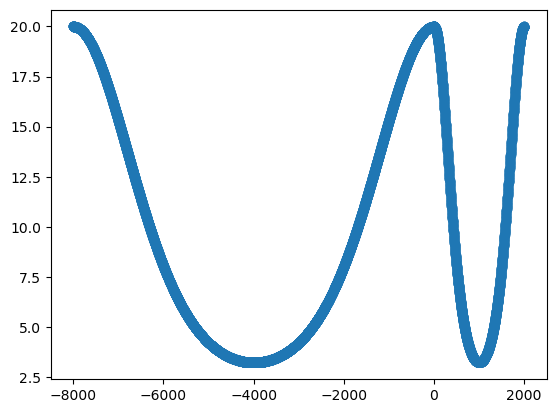

In [2]:
# Define model with N_E and N_I
myModel = Model(8000, 2000)

# Assigning parameters J, P, w^2
J = np.log(np.array([[0.63, 0.6],
                    [0.32, 0.25]]))

P = np.log(np.array([[0.11, 0.11], 
                    [0.45, 0.45]]))

w = np.log(32) * np.ones([2,2])
            
myModel.set_parameters(J, P, w)

myModel.set_inputs(1, 0)

plt.scatter(np.array(range(myModel.N)) - myModel.N_E, myModel.h)

In [3]:
myModel.generate_network()
myModel.solve_fixed_point()  # Is producing overflow error!
plt.scatter(np.array(range(myModel.N)) - myModel.N_E, myModel.r)

KeyboardInterrupt: 

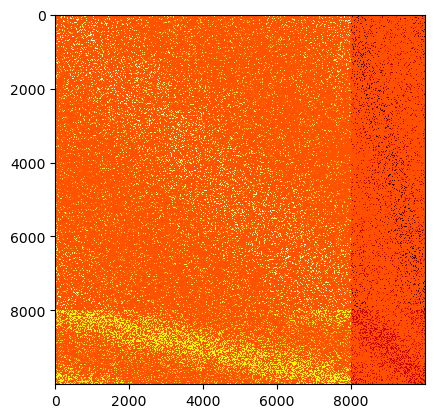

In [4]:
plt.imshow(myModel.W, cmap='hot', interpolation='nearest')
plt.show()

In [5]:
import os
k_data_path = os.path.join('Data', 'K-Data.csv')
k_data = pd.read_csv(k_data_path)

v1_data = k_data[k_data.region == 'V1']
    
print(v1_data.m.unique())
m = v1_data.m.unique()[2]
v1_data = v1_data[v1_data.m == m]
print(len(v1_data))

v1_data.head()

['Ntsr1Cre_2020_0001' 'PVCre_2019_0002' 'PVCre_2019_0009']
345600


/tmp/ipykernel_10480/2081554842.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  k_data = pd.read_csv(k_data_path)


,m,s,e,u,grat_orientation,grat_contrast,grat_spat_freq,grat_phase,response,smoothed_response,region,unit_type,response_type,invariance,fit_quality,c_inv_ts
287681,PVCre_2019_0009,2,5,2,0,0.0,0.010000,0,0.000000,0.000000,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287682,PVCre_2019_0009,2,5,2,0,0.0,0.010000,90,0.002663,0.002397,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287683,PVCre_2019_0009,2,5,2,0,0.0,0.010000,180,0.000000,0.000000,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287684,PVCre_2019_0009,2,5,2,0,0.0,0.010000,270,0.002181,0.002181,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287685,PVCre_2019_0009,2,5,2,0,0.0,0.024022,0,0.002398,0.002398,V1,excit,rising,invariant,good,2021-05-21 14:50:05


In [6]:
orientations = v1_data.grat_orientation.unique()
contrasts = v1_data.grat_contrast.unique()
spatial_frequencies = v1_data.grat_spat_freq.unique()
phases = v1_data.grat_phase.unique()
units = sorted(v1_data.u.unique())

In [7]:
def oc_matrix(u, freq=None, phase=None):
    u_data = v1_data[v1_data.u == u]
    
    if freq is not None:
        u_data = u_data[u_data.grat_spat_freq == freq]
    if phase is not None:
        u_data = u_data[u_data.grat_phase == phase]
    
    M = np.zeros((len(contrasts), len(orientations)))
    Sd = np.zeros_like(M)
    
    for i, c in enumerate(contrasts):
        con_data = u_data[u_data.grat_contrast == c]
        for j, th in enumerate(orientations):
            ori_data = con_data[con_data.grat_orientation == th]
            response = np.array(ori_data.response.tolist())
            M = M.at[i,j].set(np.mean(response))  # Seems inefficient
            Sd = Sd.at[i,j].set(np.std(response))
            
    return M, Sd

In [8]:
n_u = len(units)
n_spat = len(spatial_frequencies)

tuning_curves = np.zeros([n_u * n_spat, len(contrasts), len(orientations)])


for j, u in enumerate(units):
    for i, spf in enumerate(spatial_frequencies):
        M, Sd = oc_matrix(u, spf)
        tuning_curves = tuning_curves.at[j*n_spat + i].set(M)  # Seems inefficient


In [9]:
import pickle
with open('data_save.pkl', 'wb') as outp:
    pickle.dump(tuning_curves, outp, pickle.HIGHEST_PROTOCOL)

In [3]:
myModel.get_tuning_curves_new()
#myModel.calculate_loss(tuning_curves)

NameError: name 'tuning_curves' is not defined

In [ ]:
with open('model_save.pkl', 'wb') as outp:
    pickle.dump(myModel, outp, pickle.HIGHEST_PROTOCOL)

In [9]:
np.concatenate([np.zeros((myModel.N,)), np.array([1])])

DeviceArray([0., 0., 0., ..., 0., 0., 1.], dtype=float32)

In [8]:
np.array([1]).shape

(1,)

###### 